In [1]:
 ##THE LYBRARIES USED IN THIS NOTEBOOK
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#To avoid FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score

                               

## We load the file into pandas to see which features the dataset has

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.. I start with this dataset as I followed the ones in the course from Washington University in Coursera. If you want to take a look to the contents from the course [Machine Learning Foundations](https://www.coursera.org/learn/ml-foundations)
Here you can find a brief version of the features in the dataset:


*   Price
*   Bedrooms
*   Bathrooms
*   Sqft living
*   Sqft_lot
*   Floors

and so on 





,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


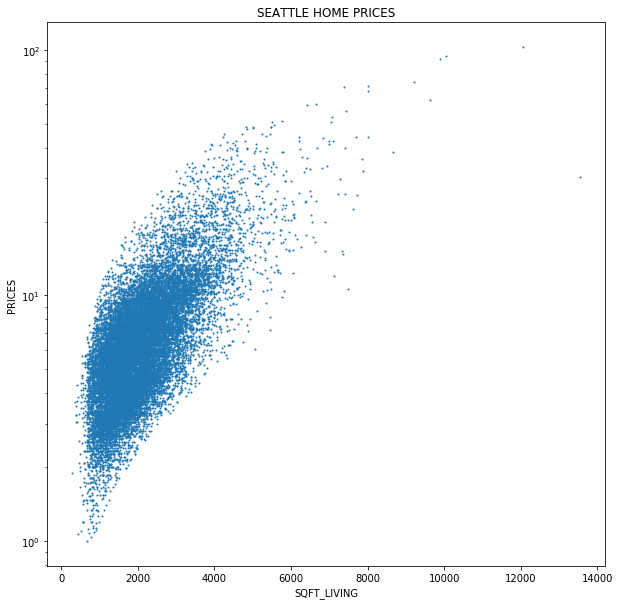

In [2]:
dataset_link = '../input/kc_house_data.csv'
houses_df = pd.read_csv(dataset_link)

minimum_y = houses_df['price'].min()
# s refers to size
#alpha --> 0.0 transparent through 1.0 opaque
plt.figure(figsize=(10,10))
plt.scatter(x = houses_df.sqft_living,y = houses_df.price/minimum_y,s = 1, alpha = 1)
plt.xlabel("SQFT_LIVING")
plt.ylabel("PRICES")
plt.title("SEATTLE HOME PRICES")
plt.yscale('log')

#Lets see what we have in the dataset
houses_df.head()


### We use a log scale as it allows a large range of elements to be displayed without small values being compressed down into bottom of the graph. If you want to see how you appreciate the change between a normal and log scale, check out this question in [Stackoverflow](https://stats.stackexchange.com/questions/27951/when-are-log-scales-appropriate)

## Explore the data

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #supress scientific notation
houses_df.describe().iloc[:,1:].drop(['yr_built','yr_renovated','zipcode'],axis=1)



,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15
count,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000
mean,540088.142,3.371,2.115,2079.900,15106.968,1.494,0.008,0.234,3.409,7.657,1788.391,291.509,47.560,-122.214,1986.552,12768.456
std,367127.196,0.930,0.770,918.441,41420.512,0.540,0.087,0.766,0.651,1.175,828.091,442.575,0.139,0.141,685.391,27304.180
min,75000.000,0.000,0.000,290.000,520.000,1.000,0.000,0.000,1.000,1.000,290.000,0.000,47.156,-122.519,399.000,651.000
25%,321950.000,3.000,1.750,1427.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,0.000,47.471,-122.328,1490.000,5100.000
50%,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,47.572,-122.230,1840.000,7620.000
75%,645000.000,4.000,2.500,2550.000,10688.000,2.000,0.000,0.000,4.000,8.000,2210.000,560.000,47.678,-122.125,2360.000,10083.000
max,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,4820.000,47.778,-121.315,6210.000,871200.000


The average sale price of a house in our dataset is close to $\$$540,088  with  most of the values falling within $\$$321,950 to $\$$645,000 range.


## Pearson Correlation

To see how each variable is correlated to the other we are gonna use the Pearson Correlation Coeficient. This is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation. 
![texto alternativo](https://www.examspm.com/wp-content/uploads/2016/07/Screen-Shot-2016-07-11-at-11.32.46-AM.png)

For any more information refer to [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)



In [4]:
correlation = houses_df.iloc[:,2:].corr(method='pearson')
correlation.style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.0,0.31,0.53,0.7,0.09,0.26,0.27,0.4,0.036,0.67,0.61,0.32,0.054,0.13,-0.053,0.31,0.022,0.59,0.082
bedrooms,0.31,1.0,0.52,0.58,0.032,0.18,-0.0066,0.08,0.028,0.36,0.48,0.3,0.15,0.019,-0.15,-0.0089,0.13,0.39,0.029
bathrooms,0.53,0.52,1.0,0.75,0.088,0.5,0.064,0.19,-0.12,0.66,0.69,0.28,0.51,0.051,-0.2,0.025,0.22,0.57,0.087
sqft_living,0.7,0.58,0.75,1.0,0.17,0.35,0.1,0.28,-0.059,0.76,0.88,0.44,0.32,0.055,-0.2,0.053,0.24,0.76,0.18
sqft_lot,0.09,0.032,0.088,0.17,1.0,-0.0052,0.022,0.075,-0.009,0.11,0.18,0.015,0.053,0.0076,-0.13,-0.086,0.23,0.14,0.72
floors,0.26,0.18,0.5,0.35,-0.0052,1.0,0.024,0.029,-0.26,0.46,0.52,-0.25,0.49,0.0063,-0.059,0.05,0.13,0.28,-0.011
waterfront,0.27,-0.0066,0.064,0.1,0.022,0.024,1.0,0.4,0.017,0.083,0.072,0.081,-0.026,0.093,0.03,-0.014,-0.042,0.086,0.031
view,0.4,0.08,0.19,0.28,0.075,0.029,0.4,1.0,0.046,0.25,0.17,0.28,-0.053,0.1,0.085,0.0062,-0.078,0.28,0.073
condition,0.036,0.028,-0.12,-0.059,-0.009,-0.26,0.017,0.046,1.0,-0.14,-0.16,0.17,-0.36,-0.061,0.003,-0.015,-0.11,-0.093,-0.0034
grade,0.67,0.36,0.66,0.76,0.11,0.46,0.083,0.25,-0.14,1.0,0.76,0.17,0.45,0.014,-0.18,0.11,0.2,0.71,0.12


In [5]:
correlation.price.sort_values(ascending=False)[1:]
#we drop the first value as it is with itself.

sqft_living      0.702
grade            0.667
sqft_above       0.606
sqft_living15    0.585
bathrooms        0.525
view             0.397
sqft_basement    0.324
bedrooms         0.308
lat              0.307
waterfront       0.266
floors           0.257
yr_renovated     0.126
sqft_lot         0.090
sqft_lot15       0.082
yr_built         0.054
condition        0.036
long             0.022
zipcode         -0.053
Name: price, dtype: float64

All the features are positively correlated with the House Price, except zipcode. The correlation of Price with Sqft_Living is the greatest, 0.702.
A negative correlation between two variables means that one variable increases whenever the other decreases. We can see the biggest  minimum of every column right below. 

In [6]:
correlated_variables = correlation.idxmin()
correlation_values = correlation.min().values

correlation_dict = {'First Variable':correlated_variables.index, 'Second Variable':correlated_variables.values, 'Values':correlation_values}
pd.DataFrame(correlation_dict)


,First Variable,Second Variable,Values
0,price,zipcode,-0.053
1,bedrooms,zipcode,-0.153
2,bathrooms,zipcode,-0.204
3,sqft_living,zipcode,-0.199
4,sqft_lot,zipcode,-0.130
5,floors,condition,-0.264
6,waterfront,long,-0.042
7,view,long,-0.078
8,condition,yr_built,-0.361
9,grade,zipcode,-0.185


## Data Visualization


Now we are gonna pick the most interesting columns in this case, price,sqft_living,sqft_lot bedrooms, bathrooms and yr_built,to see how each other is correlated to one another. 


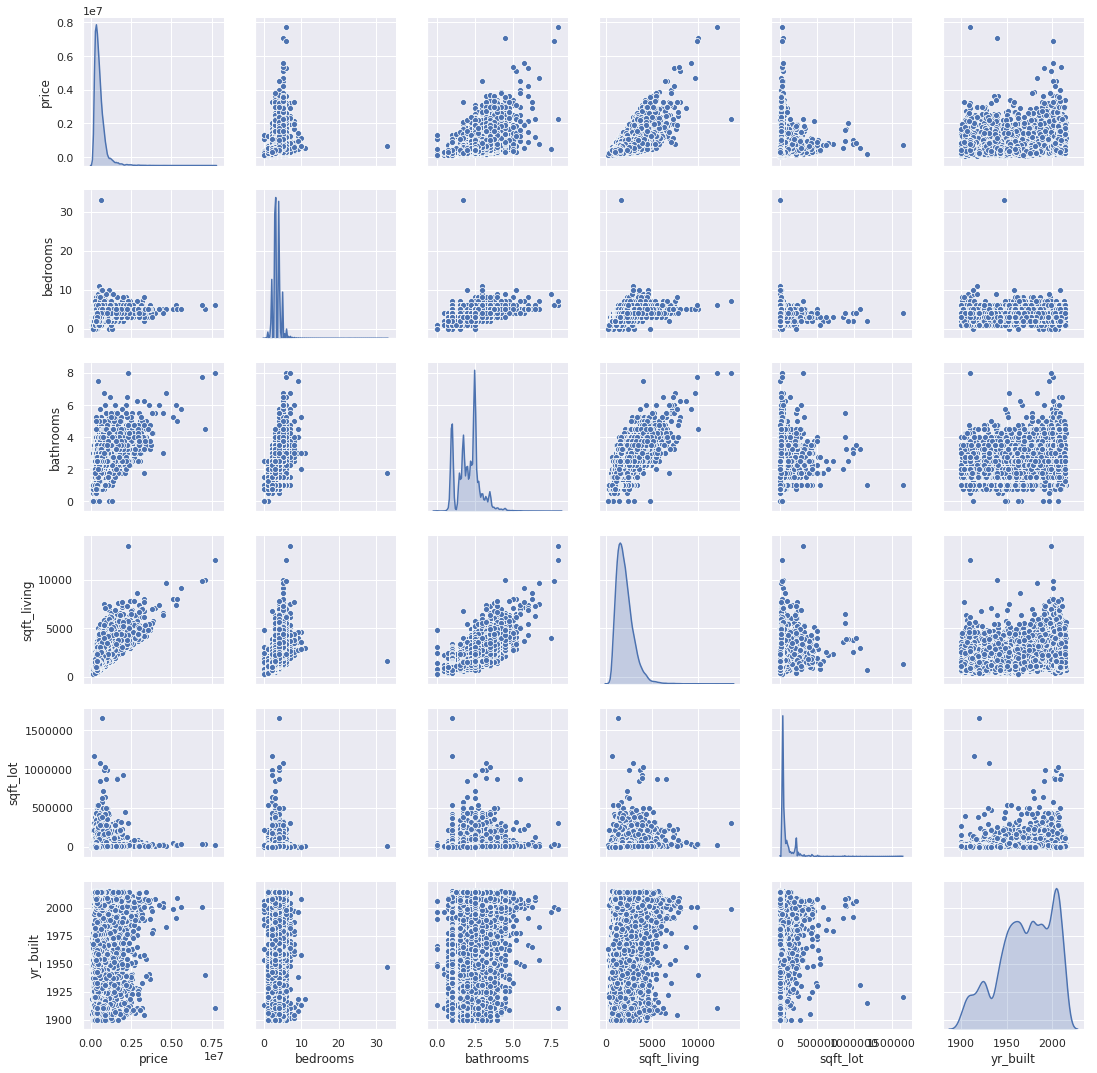

<Figure size 1800x1440 with 0 Axes>

In [7]:
sns.set(style = "ticks", color_codes=True)
correlation_features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','yr_built']
sns.set_style("darkgrid")
sns.pairplot(houses_df[correlation_features],diag_kind="kde",dropna=True)
#diag_kind:Use kernel density estimates for univariate plots:
#kind:Fit linear regression models to the scatter plots
plt.figure(figsize=(25,20))
plt.show();

By looking to the scatter plots you can observe the next :

$$Price \rightarrow  Strong\space Correlation = Sqft \space living , \space Very\space Weak \space Correlation= Year \space built$$
$$Bedrooms \rightarrow  Moderate\space Correlation = Sqft \space living , \space Very\space Weak \space Correlation= Year \space built$$
$$Bathrooms \rightarrow  Strong\space Correlation = Sqft \space living , \space Very\space Weak \space Correlation = Sqft \space Lot$$
$$Sqft \space Living \rightarrow  Strong\space Correlation = Bathroom , \space Very\space Weak \space Correlation = Sqft \space Lot$$
$$Sqft \space Lot \rightarrow  Very\space Weak \space Correlation = Sqft \space living , \space Very \space Weak \space Correlation  = Year \space built$$
$$Year \space Built \rightarrow  Moderate\space Correlation = Bathrooms  , \space Very\space  Weak \space Correlation = Sqft \space Lot $$

Here you can find the [intervals to classify the correlation ](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf). 
I think the most difficult plot to analyze is the one from Year Built because they almost all look the same. Thats when it is useful if we calculate the Pearson coefficient along the plots.

### Lets divide the dataset into training and test

In [8]:
dataset_train, dataset_test, price_train, price_test = train_test_split(houses_df,houses_df['price'],test_size=0.2,random_state=3)


## Building a Linear Regressor

Regression is the process of estimating the relationship between input data and the continuous-valued output data. This data is usually in the form of real numbers, and our goal is to estimate the underlying function that governs the mapping from the input to the output.

## Ordinary Least Squares
The first method we use is ordinary least squares and the idea behind is to find the best line that fits the data. 
<img src="https://bookdown.org/sbikienga/Intro_to_stat_book/images/chap7/ols.jpg" width="525" height="500">

 

The error function or also called the loss function ( $\epsilon_i$) is the difference between the observed values of y  (y <sub>i </sub>) and the predicted values of y (ŷ<sub>i </sub>). This term is called Residual sum of squares for more information [RSS](https://en.wikipedia.org/wiki/Residual_sum_of_squares)

The linear model is written as:

$$y_i = a + bx_i +   \epsilon_i $$

The ordinary least squares (OLS) seeks the coeeficient 'a' and 'b'. The goal is to find values of 𝑎 and 𝑏 that minimize the error. We redefine the error by the next formula

$$\epsilon(a,b)=\sum_{i=1}^n (y_i−ŷ )^2= \sum_{i=1}^n(y_i−(a+bx_i))^2$$

This requires us to find the values of (𝑎, 𝑏) such that the gradient of $\epsilon$ with respect
to our variables (which are 𝑎 and 𝑏) vanishes; thus we require

$$\frac {∂\epsilon}{∂a}=0 $$     
$$\frac {∂\epsilon}{∂b}=0$$

Differentiating $\epsilon(𝑎, 𝑏)$ yields:

$$\frac {∂\epsilon}{∂a}= 2\sum_{i=1}^n (y_i-a-bx_i)(-1)$$ 
$$\frac {∂\epsilon}{∂b}= 2\sum_{i=1}^n (y_i-a-bx_i)(-x_i)$$ 


To solve this equations remember to use:
$$ \bar{X} =\sum_{i=1}^n \frac{1}{n} x_i $$


So we will end up with the following coefficients:

$$a=\bar{y}−b\bar{x}$$

$$b=\frac {\sum_{i=1}^n (x_i−\bar{x})(y_i−\bar{y})}{\sum_{i=1}^n(x_i−\bar{x})^2} $$

**RMSE**  --> **Root Mean Square Error**

It indicates how close the observed data points are to the model's predicted values. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and is the most important criterion for fit if the main purpose of the model is prediction.



**The main advantages of using Least Squares are:**

*   Applicability: There are hardly any applications where least squares doesn’t work
*   Calculations are very fast
*   Has no paramaters to tune
*   Elemento de lista




**Disadvantages:**
 - Sensitivity to outliers
 - Tendency to overfit data. If we have many features the learned hyphotesis may fit the training set very well but fail to generalize to new examples


 



## Let's train the model only taking into account one feature from the dataset, in this case we pick up Square feet living

Ordinary Least Squares
Coefficient: 282.24681519844154
Intercept -47235.81130290171
RSS 279538024252709.97
RMSE 254289.1486936708
The model's performance is 0.50



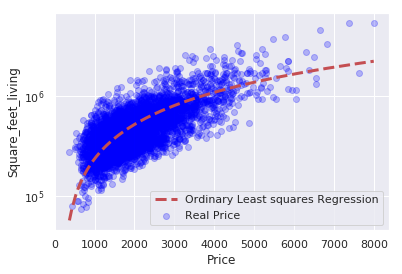

<Figure size 1080x720 with 0 Axes>

In [9]:
#Build the regression model using only sqft_living as a feature
# Create linear regression object
regression_ols = linear_model.LinearRegression()
#We convert the column sqft_living to a numpy array to make it easier to work
living_train = np.asarray(dataset_train.sqft_living)
living_train = living_train.reshape(-1,1)
#Train the model using the training sets
#Here price is the "target" data in this model, the other features are the independet variables
ols_model = regression_ols.fit(living_train, price_train)
living_test = np.asarray(dataset_test.sqft_living)
living_test = living_test.reshape(-1,1)
#We the trained dataset we make a prediction for the test dataset
prediction_test_ols = ols_model.predict(living_test)

print ('Ordinary Least Squares')
#Coefficient
print('Coefficient:',ols_model.coef_[0])
print ('Intercept', ols_model.intercept_)
# Apply the model we created using the training data to the test data, and calculate the RSS.
print('RSS',((price_test - prediction_test_ols) **2).sum())
# Calculate the RMSE ( Root Mean Squared Error)
print('RMSE', np.sqrt(metrics.mean_squared_error(price_test,prediction_test_ols)))
#The model's performance on test set is:
print('The model\'s performance is %.2f\n'% ols_model.score(living_test, price_test))



living_test_sort = np.sort(living_test.reshape(-1))
plt.scatter(living_test, price_test, color='blue', alpha=0.25,label='Real Price')
#When you plot you have to sort the array, in this case square feet living , the one that belongs to the test, if you dont do this, the plot looks weird
plt.plot(living_test_sort, ols_model.predict(living_test_sort.reshape(-1,1)),'r--',linewidth=3, label='Ordinary Least squares Regression')


plt.xlabel('Price')
plt.ylabel('Square_feet_living')
plt.legend()
plt.yscale('log')
plt.figure(figsize=(15,10))





#Blue dots are from the original data the red line is the prediction from the least squares 


plt.show()



In [10]:
actual_predicted_data_ols = pd.DataFrame({'Actual': price_test, 'Predicted': np.round(prediction_test_ols,decimals=3)})
actual_predicted_data_ols.head()


,Actual,Predicted
4131,525000.000,404359.093
17459,1870000.000,1225697.325
2192,750000.000,853131.529
12418,244900.000,127757.214
15773,275000.000,356377.134


## Lasso Regression


It's a shrinkage and variable selection method. LASSO is an acronym form Least Absolute selection and Shrinkage Operator. The Lasso imposes a constraint on the sum of the absolute values of the model parameters where the sum has a specified constant as an upper bound. This constraint causes regression coefficients for some variables to shrink towards zero. The shrinkage process identifies the variables most strongly associated with the response variable. The goal is to obtain the subset of predictors that minimized the prediction error. You should use this method when you hove more than two feautures at least.

$$ Y= \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + b $$

$ \beta_1 , \beta_2 , \beta_3 $ are coefficients of regression  


$ X_1, X_2, X_3$ are features 

The Lasso method uses $L_1$ regularization. What is that? It's a way of avoiding overfitting. 

$$\|X\|_1 = \sum_{i=1}^n|x_i|  $$

$L_1$ norm is the sum of the absolute value of the coefficients.

The cost function in Lasso is the next formula:


$$ \epsilon = Error + Penalty$$

$$ \epsilon(a,b)=\sum_{i=1}^n (y_i−ŷ )^2 + \lambda\sum_{j=1}^p |\beta_j| $$


 $$ \epsilon(a,b)=\sum_{i=1}^n(y_i−(\sum_{j=1}^p x_{ij}\beta_j))^2 +\lambda\sum_{j=1}^p|\beta_j| $$
 
###Tuning paramater $\lambda $:
It is to control the strenght of the penalty. 

*   $\lambda$ increases more coefficients are reduced to zero
*   $\lambda$ is zero then it's OLS Regression.
*   $\lambda \rightarrow \infty$ : we get $\beta=0$ all coefficients are eliminated
*   $\lambda$ increases, bias increases.
*  $\lambda$ decreases, variance increases


The **bias** is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).The **variance** is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting). For more information learn about the  [Bias and Variance Tradeoff](https://en.wikipedia.org/wiki/Bias–variance_tradeoff)




**Advantages**
- Greater prediction accuracy 
- Increase model interpretability. Reduce variance without a substantial increase in bias.
- The regression coefficients for unimportant variables are reduced to zero and produces a simple model that selects only the most important predictors.


**Disadvantages**
 
* If coefficientes are correlated , Lasso arbitrarily chooses only  one of them.
* Estimating p-values is not very straightforward



Lasso Regression
Intercept -47235.81105582765
Coefficient: 282.246815079724
RSS 279538024245681.8
RMSE 254289.14869047416
The model's performance is 0.50



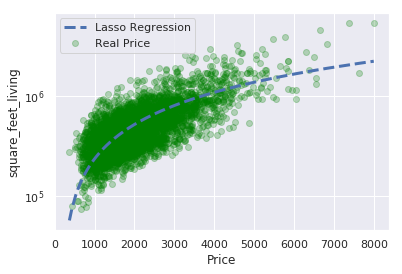

<Figure size 1080x720 with 0 Axes>

In [11]:
regression_lasso = linear_model.Lasso(alpha=.1)
lasso_model = regression_lasso.fit(living_train, price_train)
prediction_test_lasso = lasso_model.predict(living_test)

print ('Lasso Regression')
#Intercept
print ('Intercept', lasso_model.intercept_)
# Coefficient
print('Coefficient:', lasso_model.coef_[0])
# Apply the model we created using the training data to the test data, and calculate the RSS.
print('RSS',((price_test - prediction_test_lasso) **2).sum())
# Calculate the RMSE (Root Mean Squared Error)
print('RMSE', np.sqrt(metrics.mean_squared_error(price_test,prediction_test_lasso)))
# Coefficient of determination R^2 of the prediction
print('The model\'s performance is %.2f\n' % lasso_model.score(living_test, price_test))
# Plot 
plt.scatter(living_test, price_test, color='green', alpha=0.25,label='Real Price')
plt.plot(living_test_sort, lasso_model.predict(living_test_sort.reshape(-1,1)),'b--',linewidth=3, label='Lasso Regression')
plt.xlabel('Price')
plt.ylabel('square_feet_living')
plt.legend()
plt.yscale('log')
plt.figure(figsize=(15,10))

plt.show()



In [12]:
actual_predicted_data_lasso = pd.DataFrame({'Actual': price_test, 'Predicted': np.round(prediction_test_lasso,decimals=3)})

actual_predicted_data_lasso.head()

,Actual,Predicted
4131,525000.000,404359.093
17459,1870000.000,1225697.325
2192,750000.000,853131.529
12418,244900.000,127757.214
15773,275000.000,356377.135


## Ridge Regression

Aims to avoid overfitting adding a cost to the RSS term of OLS. A tuning parameter $\lambda$ controls the strength of the penalty.The $\lambda$ parameter is a scalar that should be learned  using cross validation. The penalty uses the $L_2$ (euclidean lenght) of the coefficient vector 

The Rdidge method uses $L_2$ regularization. What is that? It's a way of avoiding overfitting. 

$$\|X\|_2 =\sum_{i=1}^n|x_i|^2$$

$L_2$ norm is the sum of the squared value of the coefficients.

The cost function in Ridge is the next formula:


$$ \epsilon = Error + Penalty$$

$$ \epsilon(a,b)=\sum_{i=1}^n (y_i−ŷ )^2 + \lambda\sum_{j=1}^p |\beta_j|^2 $$


 $$ \epsilon(a,b)=\sum_{i=1}^n(y_i−( \sum_{j=1}^p x_{ij}\beta_j))^2 +\lambda\sum_{j=1}^p|\beta_j| ^2$$

**Tuning parameter $\lambda$**
  - When λ = 0, we get the linear regression estimate
  - When $\lambda\rightarrow \infty$,we get $ \beta_{j} =0$
  - For $\lambda$  in between, we are balancing two ideas: fitting a linear model of y on X, and shrinking the coefficients

As Lasso regression $ \rightarrow$ The bias increases as  $\lambda$ (amount of shrinkage) increases. And the variance decreases as $\lambda$ increases
The amount of shrinkage is controlled by $\lambda$, the tuning parameter that multiplies the ridge penalty. Large λ means more shrinkage, and so we get different coefficient estimates for different values of λ. Choosing an appropriate value of λ is important, and also difficult.


**Advantages**
   - Ridge regression performs particularly well when there is a subset of true coefficients that are small or even zero. 
   - Sparsity (Doesn't produce sparse results i.e. it does not shrink coefficients all the way to zero)
   
   
 ** Disadvantages** 
 
   - It doesn’t do as well when all of the true coefficients are moderately large


Ridge Regression
Intercept -47235.811298867804
Coefficient: 282.2468151965033
RSS 279538024252595.22
RMSE 254289.14869361863
The model's performance is 0.50



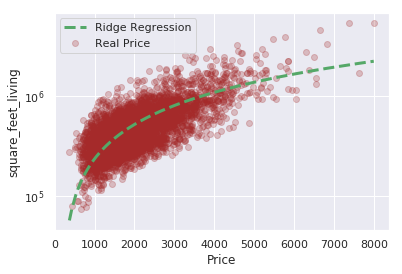

<Figure size 1080x720 with 0 Axes>

In [13]:
regression_ridge = linear_model.Ridge(alpha=[.1])
ridge_model = regression_ridge.fit(living_train, price_train)
prediction_test_ridge = ridge_model.predict(living_test)

print ('Ridge Regression')
#Intercept
print ('Intercept', ridge_model.intercept_)
# Coeficient
print('Coefficient:', ridge_model.coef_[0])
# Apply the model we created using the training data to the test data, and calculate the RSS.
print('RSS',((price_test - prediction_test_ridge) **2).sum())
# Calculate the RMSE (Root Mean Squared Error)
print('RMSE', np.sqrt(metrics.mean_squared_error(price_test,prediction_test_ridge)))
# Coefficient of determination R^2 of the prediction
print('The model\'s performance is %.2f\n' % ridge_model.score(living_test, price_test))
# Plot 
plt.scatter(living_test, price_test, color='brown', alpha=0.25,label='Real Price')
plt.plot(living_test_sort, ridge_model.predict(living_test_sort.reshape(-1,1)),'g--',linewidth=3, label='Ridge Regression')
plt.xlabel('Price')
plt.ylabel('square_feet_living')
plt.legend()
plt.yscale('log')
plt.figure(figsize=(15,10))

plt.show()

In [14]:
actual_predicted_data_ridge = pd.DataFrame({'Actual': price_test, 'Predicted': np.round(prediction_test_ridge,decimals=3)})
actual_predicted_data_ridge.head()

,Actual,Predicted
4131,525000.000,404359.093
17459,1870000.000,1225697.325
2192,750000.000,853131.529
12418,244900.000,127757.214
15773,275000.000,356377.134


## AdaBoost Algorithm

AdaBoost stands for Adaptive Boosting. When we mention boosting we refer to  aggregate a set of weak classifiers into a strong classifier.  It is adaptive in the sense that classifiers that come in next for execution are adjusted according to those instances that were wrongly classified width the previous classifiers. You could say that by just focusing on the training data samples misclassified by the previous weak classifier, each weak classifier contributes its bit the best it can  to improve the overall classification rate.  AdaBoost calls the weak classifiers repeatedly, performing a series of  $t = 1,...,T$  classifiers. In each execution, "weight" calculated by incorrectly classified examples increases (or, alternatively, weights of each correctly classified examples decreases). New classifiers are constrained to focus on those examples that were incorrectly classified by previous classifiers. 

### Disadvantages

- It is sensitive to noisy data and information that doesn't belong to the required set


### Advantagess

- in some situations, this algorithm may be less susceptible to memory input set in comparison to many other algorithms

### Basic Idea 

1- Take lots of (possibly) weak predictors

2- Weight them and add them up

3- Get a stronger predictor



**First** : Initialize the weight of each observation to $W_i =\frac { 1}{N} .$ For $ t $ in 1 to T do the following.

1- Using the weights, learn model $h_t(x_i) : X \rightarrow [0,1] $

2- Compute $ \epsilon =\sum_{i=1}^{n} w_i^t | y_i −h_t (x_i )|  $ as the error for $h_t$

3- Let $ \beta_{t} = \frac{\epsilon_{t}}{1 - \epsilon_{t}} $ and update the weights  of each of the observations  as $ w_i ^{(t+1)} = w_i^{(t)}\beta_{t}^{1-|y_i -h_t(x_i)|}  $ This scheme increases the weights of observations poorly  predicted by $h_t$ 

4- Normalize $ w^{t+1} $ so that they sum to one


RSS 264417553266886.5
RMSE 247316.1763074863
The model's performance is 0.52



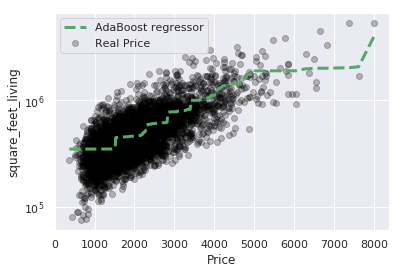

<Figure size 1080x720 with 0 Axes>

In [15]:
#n_estimators: It controls the number of weak learners.
#learning_rate:Controls the contribution of weak learners in the final combination. There is a trade-off between learning_rate and n_estimators.
#base_estimators: It helps to specify different ML algorithm. By default sklearn uses decision tree
adaboost_regressor = AdaBoostRegressor(n_estimators=1500, learning_rate = 0.001, loss='exponential')
ada_model = adaboost_regressor.fit(living_train, price_train)
prediction_test_ada = ada_model.predict(living_test)
# Apply the model we created using the training data to the test data, and calculate the RSS.
print('RSS',((price_test - prediction_test_ada) **2).sum())
# Calculate the RMSE (Root Mean Squared Error)
print('RMSE', np.sqrt(metrics.mean_squared_error(price_test,prediction_test_ada)))
#Coefficient of determination R^2 of the prediction
print('The model\'s performance is %.2f\n' % ada_model.score(living_test, price_test))
# Plot 
plt.scatter(living_test, price_test, color='black', alpha=0.25,label='Real Price')
plt.plot(living_test_sort, ada_model.predict(living_test_sort.reshape(-1,1)),'g--',linewidth=3, label='AdaBoost regressor')
plt.xlabel('Price')
plt.ylabel('square_feet_living')
plt.legend()
plt.yscale('log')
plt.figure(figsize=(15,10))

plt.show()


In [16]:

actual_predicted_data_ada = pd.DataFrame({'Actual': price_test, 'Predicted': np.round(prediction_test_ada,decimals=3)})
actual_predicted_data_ada.head()


,Actual,Predicted
4131,525000.000,450102.269
17459,1870000.000,1427878.620
2192,750000.000,797685.224
12418,244900.000,349699.918
15773,275000.000,351003.324


## Let's train the model adding more features

If we have too many features and we are not sure which ones might work the best, you can carry out a feature selection step through either PCA (Principal Components Analysis) or LDA (Linear Discriminant Analysis)




## Polynomial Curve Fitting

Consider the general form for a polynomial of order  N

$$ \hat y(x) = a_0 + a_1x^1 + a_2x^2 + ...... a_nx^n =  a_0 +\sum_{i=1}^n  a_ix^i $$

Just as was the case for linear regression, we ask, how can we pick the coefficients that best fits the curve to the data? We use the same idea:
The curve that gives minimum error between data  and the fit $\hat y (x )$ is ‘the best’


##· Error - Least squares approach

As we mentioned before the  error using the least squares approach is:
$$ \epsilon(x)= \sum_{i=1}^n (y_i - \hat y)^2 $$

$$ \epsilon(x)= \sum_{i=1}^n (y_i - (a_0 + a_1x_i^1 +a_2x_i^2 + a_3x_i^3... ))^2 $$

where 'i' is the current point and 'n' is the total number of points that we have

$$ \epsilon(x)=\sum_{i=1}^n (y_i - (a_0 +\sum_{j=1}^k  a_jx^j ))^2 $$

To  minimize this equation we proceed to take the derivative respect to each coefficient in order to find the best curve




In [17]:
dataset_train, dataset_test = train_test_split(houses_df,test_size=0.2,random_state=3)
price_train= np.asarray(dataset_train.price).reshape(-1,1)
my_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','yr_built','zipcode']
train_matrix = dataset_train.as_matrix(my_features)
regr_with_more_features = linear_model.LinearRegression()
model_least_squares = regr_with_more_features.fit(train_matrix, price_train)


matrix_test = dataset_test.as_matrix(my_features)

price_test_multiple_regression = np.asarray(dataset_test.price).reshape(-1,1)

prediction_test_least_squares = model_least_squares.predict(matrix_test)

print ('Least Squares Means')
#Coefficient
print('Coefficient:',model_least_squares.coef_[0])
#Apply the model we created using the training data to the test data, and calculate the RSE.
print('RSS',((price_test_multiple_regression - prediction_test_least_squares) **2).sum())
# Calculate the MSE
print('RMSE', np.sqrt(metrics.mean_squared_error(price_test_multiple_regression,prediction_test_least_squares)))
# Coefficient of determination R^2 of the prediction
print('The model\'s performance is %.2f\n' % model_least_squares.score(matrix_test, price_test_multiple_regression))



Least Squares Means
Coefficient: [-6.66351685e+04  6.66137293e+04  3.04489222e+02 -2.82811899e-01
  5.38124230e+04 -3.39351097e+03  6.28399099e+01]
RSS 248170781288008.34
RMSE 239597.73389849032
The model's performance is 0.55



In [18]:
price_test_multiple_regression = price_test_multiple_regression.reshape(-1)
prediction_test_least_squares  = prediction_test_least_squares.reshape(-1) 

actual_predicted_data_least_squares = pd.DataFrame({'Actual': price_test_multiple_regression, 'Predicted': np.round(prediction_test_least_squares,decimals=3)})
actual_predicted_data_least_squares.head()

,Actual,Predicted
0,525000.000,348437.108
1,1870000.000,1328478.317
2,750000.000,791693.411
3,244900.000,264810.430
4,275000.000,347495.642


 So this is the part that you ask yourself: How do I choose the best model that represents my data? In this particularly case we have to look at:

-$RMSE$

-$R^2$


I will detail a little bit about the last one.
$R^2$ It's the coefficient of determination. It explains how good is your model when compared to the baseline model.
The math formula is given by:

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

Where:

- $ \bar{y} $ is the mean of the observed data:

- $y_i$ represents the observed values

  $$ SS_{tot} =\sum_{i=1}^n (y_i - \bar{y})^2 $$

  $SS_{tot} $ quantifies how much the data points $y_i$ varies from their mean $ \bar{y}$

  $$ SS_{res} = \sum_{i=1}^n (y_i - \hat{y})^2 $$

  $SSE_{res}$ quantifies how much the data points, $y_i$ varies around the estimated regression  $ \hat{y} $


If this number is large, it is said, the regression gives a good fit . When is a large number? Well R goes from 0 to 1 for linear regressions.

- $R^2$ = 1 indicates that the regression predictions perfectly fit the data.
- $R^2$ = 0 indicates that the estimated regression line is perfectly horizontal

So... How do we interpret this coefficient?

"$R^2$ ×100 percent of the variation in y is accounted for by the variation in predictor x."

If $R^2$=0.55 then it means 55% variations in House prices is accounted for by the variation in Square Feet Living..

If you want to read more about this, check the [Statistics Program from Pennsylvania State University ](https://onlinecourses.science.psu.edu/stat501/node/255/) 

As for RMSE, the lowest the better, because it means that our prediction line is not varying that much from the actual values
So taking all this into account. Which are ours best models? According to $R^2$ and $RMSE$, our best pick is Linear regression with more features and then Adaboost algorithm. As for Linear regression if we take under consideration all the features probably we are going to have a better model.
Thats all for today, folks. I hope this comes useful to someone and don't hesitate if you have any doubt, or see an error. Drop a line!

### References

- [OLS Coefficients ](https://www.youtube.com/watch?v=EL-tayJzK7M)
- [Linear Regression](https://bookdown.org/sbikienga/Intro_to_stat_book/introduction-to-simple-linear-regression.html)
*   [Lasso and Ridge Regression](http://perso-etis.ensea.fr/tzompanaki/ML/regression.pdf)
*   [Understanding Bias Variance tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html)
*   [Ridge Regression](https://www.youtube.com/watch?v=5asL5Eq2x0A)
*   [Curve fitting](https://www.essie.ufl.edu/~kgurl/Classes/Lect3421/Fall_01/NM5_curve_f01.pdf)
*   [Adaboost](https://engineering.purdue.edu/kak/Tutorials/AdaBoost.pdf)
*   [Others criterion](http://adataanalyst.com/machine-learning/guide-for-linear-regression-using-python-part-2/)

